In [8]:
import pandas as pd
import numpy as np
import itertools as it
import os,re,sys,scipy
from collections import defaultdict

In [2]:
#import custom dependencies

sys.path.append("/cluster/bh0085/mylib")
import ipnb_utils
#dependencies from elsewhere in the C libraries
from c_create_dictionaries import list_umis

importing Jupyter notebook from c_create_dictionaries.ipynb


In [3]:
all_bcs2umis = dict()
for exp in ["HCT116_Gemcitabine2uM_BR2","HCT116_Gemcitabine2uM_BR1"]:
    print exp
    all_bcs2umis[exp] = defaultdict(list)
    for split in [str(e) for e in range(15)]:
        print split
        bcs,umis = list_umis(split = split, exp =exp)
        for i,bc in enumerate(bcs):
            all_bcs2umis[exp][bc].append(umis[i])

HCT116_Gemcitabine2uM_BR2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
HCT116_Gemcitabine2uM_BR1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [7]:
#for each positive control barcode, look up associated umis
#count the number 

#create dataframes for positive controls and all oligos from SHE2901 dataset
def indexGenerator():
    i=-1
    while 1:
        i+=1
        yield i

from scipy import stats
scipy.stats.entropy
#stats.entropy(["hi","hello"])
def my_entropy(arr):
    if len(arr)==0:
        return 0
    m = stats.mode(arr)
    return float(m.count[0]) / len(arr)

gen = indexGenerator()
positive_oligos_raw = pd.read_csv("../data/SHE2901_positive_controls_barcoded.csv")
positive_oligos = pd.DataFrame.from_dict(dict([(gen.next(),{"oligo_seq":v.Sequence,"barcode":e}) for k,v in positive_oligos_raw.iterrows() if type(v.barcode)==str for e in v.barcode.split(",")]),orient="index")

gen = indexGenerator()
all_oligos_raw = pd.read_csv("../data/umi_oligo_corrected_dict.csv",index_col=0)
all_oligos = pd.DataFrame.from_dict(dict([(gen.next(),{"oligo_seq":v.oligo_seq,"barcode":v.name}) for k,v in all_oligos_raw.iterrows() if pd.notna(v.oligo_seq) and pd.notna(v.name)]),orient="index")

annotations = defaultdict(dict)
for exp in ["HCT116_Gemcitabine2uM_BR2","HCT116_Gemcitabine2uM_BR1"]:
  bcs2umis = all_bcs2umis[exp]
  for j,oligos in enumerate([positive_oligos, all_oligos]):
    ann = oligos.copy()
    annotations[exp][j] = ann
    
    for i,bc in ann.barcode.items():
        dist1_seqs = [e for e in [ bc[0:pos]+let+bc[pos+1:15] for pos in range(15) for let in "ATGC"  ] if e != bc]
        random_seqs = ["".join(["ATGC"[np.random.randint(4)] for i2 in range(15)]) for j2 in range(45) ]
        random1_seqs = ["".join(["ATGC"[np.random.randint(4)] for i2 in range(15)]) for j2 in range(1) ]

        
        ann.at[i,"n_exact_umis"] = len(bcs2umis[bc])+1 if bc in bcs2umis else 0
        ann.at[i,"n_exact_distinct_umis"] = len(set(bcs2umis[bc])) if bc in bcs2umis else 0
        ann.at[i,"n_dist1_umis"] = sum([len(bcs2umis[seq]) for seq in dist1_seqs if seq in bcs2umis])
        ann.at[i,"n_rand_umis"] = sum([len(bcs2umis[seq]) for seq in random_seqs if seq in bcs2umis])
        
        ann.at[i,"umi_redundancy_factor"] =len(bcs2umis.get(bc,[])) / len(set(bcs2umis.get(bc,[]))) if bc in bcs2umis else 0
        ann.at[i,"rand_umis_redundancy_factor"] =np.mean([len(bcs2umis.get(seq,[])) / len(set(bcs2umis.get(seq,[]))) for seq in random_seqs if seq in bcs2umis ])
        ann.at[i,"dist1_umis_redundancy_factor"] =np.mean([len(bcs2umis.get(seq,[])) / len(set(bcs2umis.get(seq,[]))) for seq in dist1_seqs if seq in bcs2umis ])
        
        ann.at[i,"umi_entropy_factor"] =my_entropy(bcs2umis.get(bc) if bc in bcs2umis else []) 
        ann.at[i,"rand_umis_entropy_factor"] =np.mean(list([my_entropy(bcs2umis.get(seq,[])) for seq in random_seqs if seq in bcs2umis ]))
        ann.at[i,"dist1_umis_entropy_factor"] =np.mean(list([my_entropy(bcs2umis.get(seq,[])) for seq in dist1_seqs if seq in bcs2umis ]))

        try:
            best = sorted(dist1_seqs,key = lambda x: len(set(bcs2umis[x])) if x in bcs2umis else 0 )[-1]
            ann.at[i,"n_best_inexact_umi"] = len(bcs2umis[best]) if best in bcs2umis else 0
            ann.at[i,"n_best_inexact_distinct_umi"] = len(set(bcs2umis[best])) if best in bcs2umis else 0
        except ValueError:
            ann.at[i,"n_best_inexact_umi"] = 0
            ann.at[i,"n_best_inexact_distinct_umi"] = 0
                
        try:
            best = sorted(random_seqs,key = lambda x: len(set(bcs2umis[x])) if x in bcs2umis else 0 )[-1]
            ann.at[i,"n_best_rand_umi"] = len(bcs2umis[best]) if best in bcs2umis else 0
            ann.at[i,"n_best_rand_distinct_umi"] = len(set(bcs2umis[best])) if best in bcs2umis else 0

        except ValueError:
            ann.at[i,"n_best_rand_umi"] = 0
            ann.at[i,"n_best_rand_distinct_umi"] = 0

                            
        try:
            best = sorted(random1_seqs,key = lambda x: len(set(bcs2umis[x])) if x in bcs2umis else 0 )[-1]
            ann.at[i,"n_best_rand1_umi"] = len(bcs2umis[best]) if best in bcs2umis else 0
            ann.at[i,"n_best_rand1_distinct_umi"] = len(set(bcs2umis[best])) if best in bcs2umis else 0

        except ValueError:
            ann.at[i,"n_best_rand1_umi"] = 0
            ann.at[i,"n_best_rand1_distinct_umi"] =0

#plotted in FIG 1


/cluster/bh0085/anaconda27/lib/python2.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


# PLOTTING

In [20]:
#plotting section
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

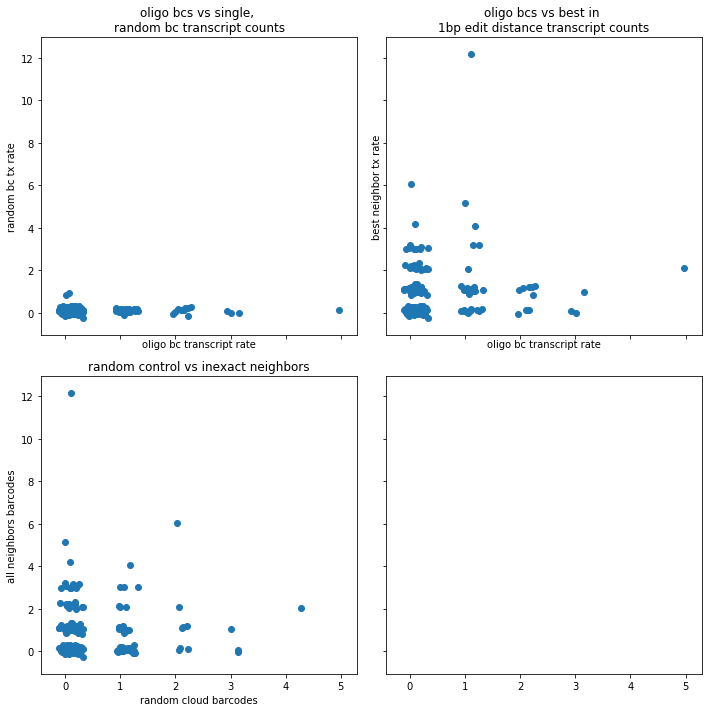

In [22]:
noises = [np.random.normal(0*ann.n_best_inexact_distinct_umi+.1,.1),np.random.normal(0*ann.n_best_inexact_distinct_umi+.1,.1)]

f,subs=plt.subplots(2,2,sharex=True,sharey=True)
f.set_size_inches([10,10])
subs[0][1].scatter(noises[1]+ann.n_exact_distinct_umis,noises[0]+ann.n_best_inexact_distinct_umi)
subs[1][0].scatter(noises[1]+ann.n_best_rand_distinct_umi,noises[0]+ann.n_best_inexact_distinct_umi)
subs[0][0].scatter(noises[1]+ann.n_exact_distinct_umis,noises[0]+ann.n_best_rand1_distinct_umi)

subs[0][0].set_title("oligo bcs vs single, \nrandom bc transcript counts")
subs[0][1].set_title("oligo bcs vs best in \n1bp edit distance transcript counts")
subs[0][0].set_xlabel("oligo bc transcript rate")
subs[0][1].set_xlabel("oligo bc transcript rate")
subs[0][0].set_ylabel("random bc tx rate")
subs[0][1].set_ylabel("best neighbor tx rate")

subs[1][0].set_title("random control vs inexact neighbors")
subs[1][0].set_xlabel("random cloud barcodes")
subs[1][0].set_ylabel("all neighbors barcodes")



plt.tight_layout()
        
        
        

In [30]:
annotations.values()[0][0]

,oligo_seq,barcode,n_exact_umis,n_exact_distinct_umis,n_dist1_umis,n_rand_umis,umi_redundancy_factor,rand_umis_redundancy_factor,dist1_umis_redundancy_factor,umi_entropy_factor,rand_umis_entropy_factor,dist1_umis_entropy_factor,n_best_inexact_umi,n_best_inexact_distinct_umi,n_best_rand_umi,n_best_rand_distinct_umi,n_best_rand1_umi,n_best_rand1_distinct_umi
0,CAAACGCTCTAAATTTAGTCTCTCTGATGTGTCCTCCGTTTCCTGC...,CTTTAAGCCGCAAGG,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,CAAACGCTCTAAATTTAGTCTCTCTGATGTGTCCTCCGTTTCCTGC...,CACGCCTACCAAATA,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,CAAACGCTCTAAATTTAGTCTCTCTGATGTGTCCTCCGTTTCCTGC...,AGCCACGCTTGCACA,0.0,0.0,1.0,18.0,0.0,18.0,1.000000,0.000000,1.000000,1.000000,1.0,1.0,18.0,1.0,0.0,0.0
3,CAAACGCTCTAAATTTAGTCTCTCTGATGTGTCCTCCGTTTCCTGC...,CCCCAGGGCATAGAA,15.0,1.0,0.0,0.0,14.0,NaN,NaN,1.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,CAAACGCTCTAAATTTAGTCTCTCTGATGTGTCCTCCGTTTCCTGC...,GGGTATTTCAGGCGG,0.0,0.0,7.0,0.0,0.0,NaN,7.000000,0.000000,NaN,1.000000,7.0,1.0,0.0,0.0,0.0,0.0
5,CAAACGCTCTAAATTTAGTCTCTCTGATGTGTCCTCCGTTTCCTGC...,CCCCTGCATTTCCCG,15.0,2.0,1.0,0.0,7.0,NaN,1.000000,0.928571,NaN,1.000000,1.0,1.0,0.0,0.0,0.0,0.0
6,GTCCTCCGTTTCCTGCCCCTGCTGCCCTCCTTTCAAGGCGATGAGG...,CACGACGACGTCGGA,11.0,2.0,1.0,0.0,5.0,NaN,1.000000,0.900000,NaN,1.000000,1.0,1.0,0.0,0.0,0.0,0.0
7,GTCCTCCGTTTCCTGCCCCTGCTGCCCTCCTTTCAAGGCGATGAGG...,CTCACGCGCAGTTAT,0.0,0.0,16.0,0.0,0.0,NaN,16.000000,0.000000,NaN,1.000000,16.0,1.0,0.0,0.0,0.0,0.0
8,TTTCAAGGCGATGAGGTCACCCCGGAACTGCCTGCCCCAGCAGCCA...,AACGTTGGGCGCATG,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
9,TTTCAAGGCGATGAGGTCACCCCGGAACTGCCTGCCCCAGCAGCCA...,CCCACCGGCTTTGGT,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


AttributeError: 'DataFrame' object has no attribute 'umi_entropy_factor'

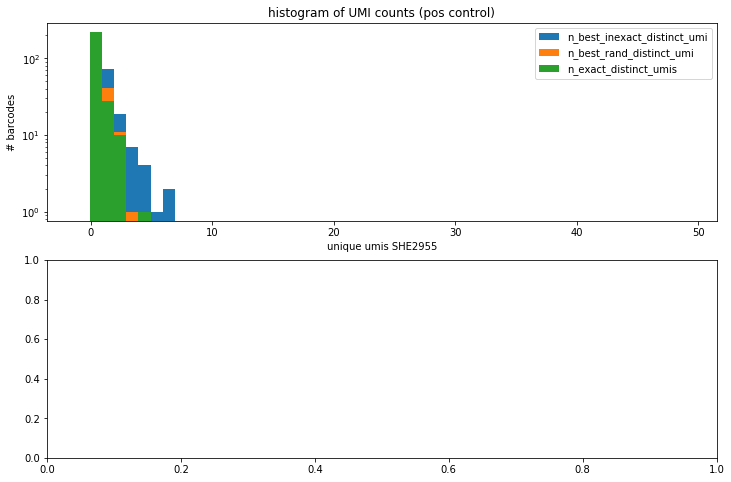

In [35]:
#FIG 1
#histogram of the number of exact umi matches in SHE2955 positive control & full set vs the number of distance 1 matches
f,subs = plt.subplots(2,1)
f.set_figwidth(10)
f.set_size_inches([12,8])

bins =[-1]+ np.linspace(-.1,50,51)

sub = subs[0]
ann = annotations.values()[0][0]

#h1 = sub.hist(ann.n_exact_umis, bins = bins)
h = sub.hist(ann.n_best_inexact_distinct_umi, bins = bins)
h = sub.hist(ann.n_best_rand_distinct_umi, bins = bins)
h1 = sub.hist(ann.n_exact_distinct_umis, bins = bins)


#h = sub.hist(ann.n_rand_umis, bins = bins)

sub.set_title("histogram of UMI counts (pos control)")
sub.set_xlabel("unique umis SHE2955")
sub.set_ylabel("# barcodes")
sub.set_yscale("log")
sub.legend()

bins = np.linspace(0,1,20)
sub = subs[1]
ann = annotations.values()[1][0]

h1= np.histogram(po_ann.umi_entropy_factor,bins=bins)
h2= np.histogram(po_ann.dist1_umis_entropy_factor.where(pd.notna,other=0),bins=bins)
h3= np.histogram(po_ann.rand_umis_entropy_factor.where(pd.notna,other=0),bins=bins)

w = np.min(np.diff(h1[1]))/4
sub.bar(h1[1][:-1],h1[0],w, label = "umi")
sub.bar(h2[1][:-1]-w,h2[0],w, label="dist1")
sub.bar(h3[1][:-1]+w,h3[0],w, label="rand")

sub.legend()
sub.set_yscale("log")

# sub = subs[1]
# ann = ao_ann
# h = sub.hist(ann.n_best_inexact_umi, bins = bins)
# h = sub.hist(ann.n_best_rand_umi, bins = bins)
# h1 = sub.hist(ann.n_exact_umis, bins = bins)
# sub.set_title("histogram of UMI counts (pos control)")
# sub.set_xlabel("unique umis SHE2955")
# sub.set_ylabel("# barcodes")
# sub.set_yscale("log")
# sub.legend()
# plt.tight_layout()



In [34]:
ann

,oligo_seq,barcode,n_exact_umis,n_exact_distinct_umis,n_dist1_umis,n_rand_umis,umi_redundancy_factor,rand_umis_redundancy_factor,dist1_umis_redundancy_factor,umi_entropy_factor,rand_umis_entropy_factor,dist1_umis_entropy_factor,n_best_inexact_umi,n_best_inexact_distinct_umi,n_best_rand_umi,n_best_rand_distinct_umi,n_best_rand1_umi,n_best_rand1_distinct_umi
0,CCTGGGGCTGCCAGGGGCTGAAGTGTTGATGTTAACTGCCGGGATC...,CCCTGTGTCGTTAAC,18.0,1.0,1.0,11.0,17.0,5.0,1.000000,1.000000,0.909091,1.000000,1.0,1.0,11.0,2.0,0.0,0.0
1,GCATGGTGATGGTTTCCCCACGTTTGAATCCCCAAGCCTCCTGGGA...,GGCCACCGAAGCGCT,0.0,0.0,0.0,8.0,0.0,4.0,NaN,0.000000,0.875000,NaN,0.0,0.0,8.0,2.0,0.0,0.0
2,TAGTTTACAATTATTAGATACACTGATGCATAGGAGGATGCAGGAC...,TGAATTATAGAAACT,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,CAGGTCTACCTCTCAGCCGCTCCCAAGCCTGAGCTTGGTGACGGAG...,AATCCCATAAGCGAC,0.0,0.0,11.0,0.0,0.0,NaN,5.000000,0.000000,NaN,0.727273,11.0,2.0,0.0,0.0,0.0,0.0
4,TCAAGTAGGCTCTTCCAGAAGGTTTTCCCTCCTGGGATGTCTGTGT...,CCGTCCAAAAGTTAA,0.0,0.0,0.0,11.0,0.0,11.0,NaN,0.000000,1.000000,NaN,0.0,0.0,11.0,1.0,0.0,0.0
5,AAATAAACTAAGGGGCATTGGGAACACGCTCCTGCCACCTCCACAC...,AGAAACTTAATTACG,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
6,TTGGGGTGGGGGGGCGGGGCGGCAGGGGACGGAGTTTCACTCTTAT...,AGTCCACTAAAGGAT,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
7,GCGGTCACTCTGAAGTGATGTAAGCCTCCTGTGTCCTAAGAGCAAC...,GGAGCGTTGTCCTTC,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
8,ACATGGACCACATACAAGTGGACCAAGAATCCTGACTTTCTGGCTT...,TATCTAGTGATAATG,0.0,0.0,10.0,0.0,0.0,NaN,10.000000,0.000000,NaN,1.000000,10.0,1.0,0.0,0.0,0.0,0.0
9,CCTTCTCCAGTGCCAGCACCTGGGCCAGCAGCTGCCCCTCCAGCTG...,GCGGCTCCTCGGCCG,8.0,1.0,0.0,0.0,7.0,NaN,NaN,1.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:


#FIG 1
#histogram of the number of exact umi matches in SHE2955 positive control & full set vs the number of distance 1 matches
f,subs = plt.subplots(2,2)
f.set_figwidth(10)
f.set_size_inches([15,10])

bins =[-1]+ np.linspace(.1,1500,75)
ebins =[-1]+ np.linspace(.1,90,90)

sub = subs[0,0]
h = sub.hist(po_ann.n_dist1_umis, bins = bins)
h1 = sub.hist(po_ann.n_exact_umis, bins = bins)
h2 = sub.hist(po_ann.n_rand_umis, bins = bins)
sub.set_title("histogram of UMI counts (pos control)")
sub.set_xlabel("unique umis SHE2955")
sub.set_ylabel("# barcodes")
sub.set_yscale("log")
sub.legend()

sub2 = subs[0,1]
h4 = sub2.hist(po_ann.n_best_inexact_umi, bins = ebins)
h3 = sub2.hist(po_ann.n_exact_umis, bins = ebins)
h5 = sub2.hist(po_ann.n_best_rand_umi, bins = ebins)

sub2.set_yscale("log")
sub2.set_title("discovery rate of barcode sequence, best single mutation, and random control")
sub2.legend()


sub = subs[1,0]
sub.hist(ao_ann.n_dist1_umis, bins = bins)
sub.hist(ao_ann.n_exact_umis, bins = bins)
sub.hist(ao_ann.n_rand_umis, bins = bins)
sub.set_title("histogram of transcript UMI counts observed for all oligos")
sub.set_xlabel("unique umis SHE2955")
sub.set_ylabel("# barcodes")
sub.set_yscale("log")
sub.legend()

sub2 = subs[1,1]
h4 = sub2.hist(ao_ann.n_best_inexact_umi, bins = ebins)
h3 = sub2.hist(ao_ann.n_exact_umis,bins = ebins)
h5 = sub2.hist(ao_ann.n_best_rand_umi, bins = ebins)

sub2.set_yscale("log")
sub2.set_title("discovery rate of barcode sequence, best single mutation, and random control")
sub2.legend()

#po_ann["n_exact_umis"].values

In [ ]:
#histogram of the number of umis mapped to each oligo sequence


all_lens = [len(g) for k,g in all_oligos.groupby("oligo_seq")]
pos_lens = [len(g) for k,g in positive_oligos.groupby("oligo_seq")]
    
fig,sub = plt.subplots(1,1)

bins = np.linspace(-1,50,51)
sub.hist(all_lens, bins = bins, color = [1,0,0,.25])
sub.twinx().hist(pos_lens, bins = bins, color = [1,1,0,.25])
sum(pos_lens)

In [ ]:
print np.mean(all_lens)
print np.mean(pos_lens)
len(pos_lens)
